In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# astronomical units and constants
import astropy.units as u
from astropy.constants import R_sun


from matplotlib.lines import Line2D

import os
CWD = "/".join(os.getcwd().split("/")[:-2])
# Plot stuff
from funcs.model import full_model, aflare

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable


from funcs.helper import fetch_lightcurve
from funcs.multiperiod import find_period
from scipy import optimize

def cosine(x, a, b, c, d, e):
    """cosine with a linear trend"""
    return a * np.cos(b * x + c) + d * x + e

In [ ]:
# Datasets we analysed
datasets = [#(237880881, "a", "03_10_2020_11_29"),
            #(237880881, "b", "03_10_2020_11_29"),
            (100004076, "", "03_10_2020_11_27"),
#             (277539431, "", "08_07_2020_11_48"),
#             (237880881, "a", "11_02_2020_10_07"),
#             (237880881, "b", "11_02_2020_10_07"),
#             (44984200, "", "02_08_2020_17_44"),
#             (44984200, "a", "04_08_2020_13_40"),
#             (44984200, "b", "04_08_2020_13_40"),
#             (100004076, "", "18_08_2020_15_38"),
            ]

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.


TIC 237880881 modulation period:  8.440140530163145 h
Relative amplitude of modulation: -1.3e-02


findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.440140530163145 h
Relative amplitude of modulation: -1.3e-02


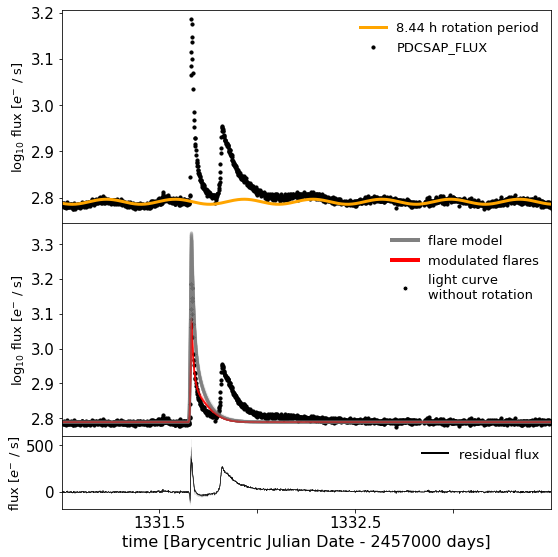

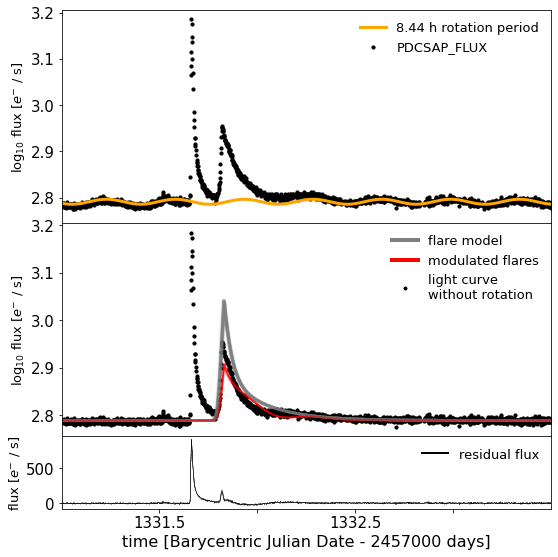

In [3]:


for ID, suffix, tstamp in datasets:

    # Get data
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    inits = inits[(inits.ID == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg/ u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun

    # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    inds = np.random.randint(df.shape[0], size=N)
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    ax.scatter(time, np.log10(flux), s=10, c="k",label=r"de-trended light curve")

    for ind in inds:
        sample = df.loc[ind,]

        a = sample.a
        phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
        theta_a = sample.latitude_deg / 180 * np.pi
        fwhm = sample.fwhm_d / target.Prot_d * 2 * np.pi
        i = sample.i_deg / 180 * np.pi
        
        phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
        flare = aflare(phi, phi_a, fwhm, a*median)+ median
        fullmodel = full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel) , c="r", alpha=0.05)
        ax2.plot(time, flux-fullmodel, c="k", alpha=.05, linewidth=.5)



    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    ax3.scatter(flck.time, np.log10(flck.flux),c="k",s=10,
             label=(f"PDCSAP_FLUX"))#{target.prefix} {target.ID},"\
                    #f" S{target.QCS}, {target.SpT}V"))
    ax3.plot(flck.time, np.log10(model),linewidth=3,
                 c="orange",label=f"{period:.2f} rotation period")    
    ax3.legend(loc=1, frameon=False, fontsize=13)


    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                       Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                       Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                              markerfacecolor='k', markersize=5),]
    legend_elements2 = [
                       Line2D([0], [0], color='k', lw=2, label="residual flux"),
                      ]




    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    ax2.legend(handles=legend_elements2, fontsize=13, frameon=False)
    ax2.set_xlabel(f"time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)


    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)

    ax.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);

    ax2.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    plt.tight_layout()
    plt.ylim(None, None)
    x = np.linspace(lc.t.min(), lc.t.max(), 10)
    yd = np.full_like(x, ax3.get_ylim()[0])
    yu = np.full_like(x, ax3.get_ylim()[1])
    #ax.fill_between(x,yd,yu,facecolor="orange",alpha=.26)
    #ax3.fill_between(x,yd,yu,facecolor="orange",alpha=.13)
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
#     plt.savefig(f"{CWD}/analysis/plots/flarefit/"
#                 f"Nature_{target.prefix}{target.ID}{suffix}.png",
#                 dpi=300)

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.


TIC 237880881 modulation period:  8.440140530163145 h
Relative amplitude of modulation: -1.3e-02


findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.440140530163145 h
Relative amplitude of modulation: -1.3e-02


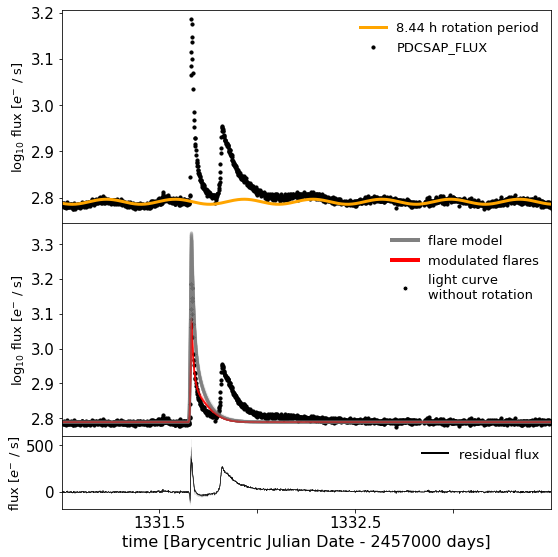

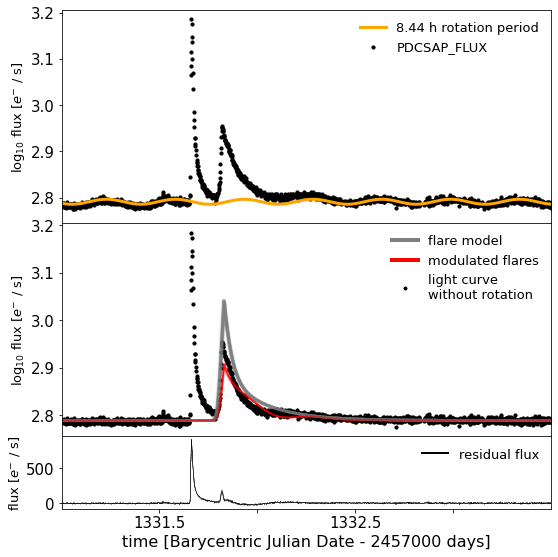

In [3]:
for ID, suffix, tstamp in datasets:

    # Get data
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    inits = inits[(inits.ID == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg/ u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun

    # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    inds = np.random.randint(df.shape[0], size=N)
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)

    ax.scatter(time, np.log10(flux), s=10, c="k",label=r"de-trended light curve")

    for ind in inds:
        sample = df.loc[ind,]

        a = sample.a
        phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
        theta_a = sample.latitude_deg / 180 * np.pi
        fwhm = sample.fwhm_d / target.Prot_d * 2 * np.pi
        i = sample.i_deg / 180 * np.pi
        
        phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi)
        flare = aflare(phi, phi_a, fwhm, a*median)+ median
        fullmodel = full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        equator = full_model(phi_a, 0., a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, np.log10(equator), c="g", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel) , c="r", alpha=0.05)
        ax2.plot(time, flux-fullmodel, c="k", alpha=.05, linewidth=.5)



    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    ax3.scatter(flck.time, np.log10(flck.flux),c="k",s=10,
             label=(f"PDCSAP_FLUX"))#{target.prefix} {target.ID},"\
                    #f" S{target.QCS}, {target.SpT}V"))
    ax3.plot(flck.time, np.log10(model),linewidth=3,
                 c="orange",label=f"{period:.2f} rotation period")    
    ax3.legend(loc=1, frameon=False, fontsize=13)


    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                       Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                       Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                              markerfacecolor='k', markersize=5),]
    legend_elements2 = [Line2D([0], [0], color='k', lw=2, label="residual flux"),]


    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    ax2.legend(handles=legend_elements2, fontsize=13, frameon=False)
    ax2.set_xlabel(f"time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)


    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)

    ax.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);

    ax2.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    plt.tight_layout()
    plt.ylim(None, None)
    x = np.linspace(lc.t.min(), lc.t.max(), 10)
    yd = np.full_like(x, ax3.get_ylim()[0])
    yu = np.full_like(x, ax3.get_ylim()[1])
    #ax.fill_between(x,yd,yu,facecolor="orange",alpha=.26)
    #ax3.fill_between(x,yd,yu,facecolor="orange",alpha=.13)
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
#     plt.savefig(f"{CWD}/analysis/plots/flarefit/"
#                 f"Nature_{target.prefix}{target.ID}{suffix}.png",
#                 dpi=300)

# Backlog

FileNotFoundError: [Errno 2] File /work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/mcmc/03_10_2020_11_29_237880881_raw_mcmc_sample.csv does not exist: '/work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/mcmc/03_10_2020_11_29_237880881_raw_mcmc_sample.csv'

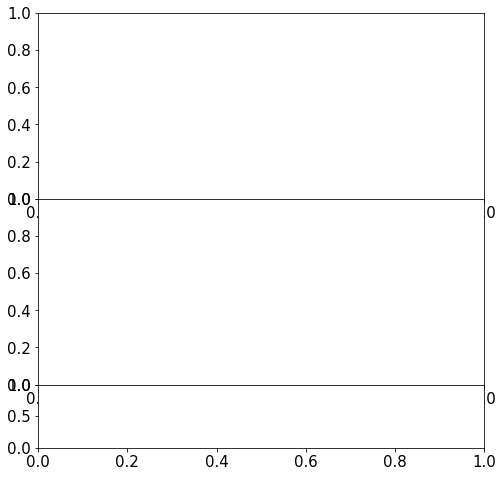

In [7]:
# Datasets we analysed
datasets = [(237880881,"03_10_2020_11_29")
            #(237880881,"11_02_2020_10_07"),
            
            #(44984200, "04_08_2020_13_40")
           ]
            

for ID, tstamp in datasets:
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")

    # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    
    fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(8,8),sharex=True)
    divider = make_axes_locatable(ax3)

    ax = divider.append_axes("bottom", size="100%", pad=0)
    ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax3.figure.add_axes(ax2)
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}_raw_mcmc_sample.csv")
    print(df.columns)
    inds = np.random.randint(df.shape[0], size=N)

    ax.scatter(time, np.log10(flux), s=10, c="k",label=r"de-trended light curve")
    resida, residb = [], []
    for suffix in ['a','b']:
        #Get data
        di = {"a":resida,"b":residb}
        df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")
        inds = np.random.randint(df.shape[0], size=N)
    inits_ = inits[(inits.ID == str(ID)+suffix) & (inits.tstamp==tstamp)].iloc[0]

    qlum = inits_.qlum_erg_s * u.erg / u.s
    Fth = inits_.Fth * u.erg/ u.cm**2 / u.s
    median = inits_['median']
    R = inits_.R_Rsun * R_sun
    #print(qlum, Fth, median, R)
    for ind in inds:
        sample = df.loc[ind,]
        aa, ab = sample.a_a, sample.a_b
        phi_aa = sample.phase_peak_a
        phi_ab = sample.phase_peak_b
        theta_a = sample.latitude_rad
        fwhma = sample.fwhm_periods_a 
        fwhmb = sample.fwhm_periods_b 
        i = sample.i_rad
        phi0 = sample.phase_0
        flarea = aflare(phi, phi_aa, fwhma, aa*median)+ median
        flareb = aflare(phi, phi_ab, fwhmb, ab*median)+ median
        fullmodela = full_model(phi_aa, theta_a, aa, fwhma, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        fullmodelb = full_model(phi_ab, theta_a, ab, fwhmb, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)
        ax.plot(time, np.log10(flareb), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodelb) , c="r", alpha=0.05)
        ax.plot(time, np.log10(flarea), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodela) , c="r", alpha=0.05)
#             di[suffix].append(fullmodel)
        ax2.plot(time, flux-fullmodela-fullmodelb+median, c="k", alpha=.05, linewidth=.5)
        print("L",len(di[suffix]))

#     for resa, resb in zip(resida,residb):        
#         ax2.plot(time, flux-resa-resb, c="k", alpha=.05, linewidth=.5)



    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    ax3.scatter(flck.time, np.log10(flck.flux),c="k",s=10)#{target.prefix} {target.ID},"\
                    #f" S{target.QCS}, {target.SpT}V"))
    ax3.plot(flck.time, np.log10(model),linewidth=3, c="orange",label=f"{period:.2f} rotation period")    
   # ax3.legend(loc=1, frameon=False, fontsize=13)
#     arr = np.array([resida,residb])#.reshape((N,2,len(flux))) # (X, N, 2)
#     print(arr.shape)
#     for i in range(N):
#         ro = arr[:,i,:] 
#         print(ro.shape)
#         ax2.plot(time, flux-ro[0,:]-ro[1,:]+median, c="k", alpha=.05, linewidth=.5)
#    # for subarr in arr[:,]

    legend_elements = [Line2D([0], [0], color='grey', lw=4, label="flare model"),
                       Line2D([0], [0], color='r', lw=4, label="modulated flares"),
                       Line2D([0], [0], marker='o', color='w', 
                              label="light curve \nwithout rotation",
                              markerfacecolor='k', markersize=5),]
    legend_elements2 = [Line2D([0], [0], color='k', lw=2, label="residual flux"),]
    legend_elements3 = [Line2D([0], [0],  marker='o', color='w',
                               markerfacecolor='k', markersize=10,
                               label=f"PDCSAP_FLUX"),
                        Line2D([0], [0], color='orange', lw=4, label=f"{period:.2f} rotation period")]




    ax.legend(handles=legend_elements, fontsize=13, frameon=False)
    ax2.legend(handles=legend_elements2, fontsize=13, frameon=False)
    ax3.legend(handles=legend_elements3, fontsize=13, frameon=False)
    ax2.set_xlabel(f"time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)


    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    for label in ax3.xaxis.get_ticklabels():
        label.set_visible(False)

    ax.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);
    ax3.set_ylabel(r"$\log_{10}$ flux [$e^{-}$ / s]",fontsize=13);

    ax2.set_ylabel(r"flux [$e^{-}$ / s]",fontsize=13);
    plt.tight_layout()
    plt.ylim(None, None)
    x = np.linspace(lc.t.min(), lc.t.max(), 10)
    yd = np.full_like(x, ax3.get_ylim()[0])
    yu = np.full_like(x, ax3.get_ylim()[1])
    ax.fill_between(x,yd,yu,facecolor="orange",alpha=.26)
    ax3.fill_between(x,yd,yu,facecolor="orange",alpha=.13)
    for axis in [ax, ax2, ax3]:
        axis.set_xlim(lc.t.min(), lc.t.max())
#     plt.savefig(f"{CWD}/analysis/plots/flarefit/Nature_{target.prefix}{target.ID}merge2.png",  dpi=300)

In [ ]:
8.8706892e+30 erg / s 90616286040.1588 erg / (cm2 s) 615.088583574826 191422550.70000002 m

In [ ]:
plt.plot(lc.flux)